# Programming and Maths for AI: Task 2

In [1]:
# load libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

##### Set random seeds to make results reproducible

In [2]:
# set seeds
torch.manual_seed(2020)
np.random.seed(2020)

##### Choose the ECG200 dataset for a time-series classification task

In [3]:
# load data
train = np.loadtxt("ECG200_TRAIN.txt")
test  = np.loadtxt("ECG200_TEST.txt")

# the first column is label
X_train = train[:, 1:]       
y_train = train[:, 0].astype(int)     
X_test  = test[:, 1:]              
y_test  = test[:, 0].astype(int)

# original label is -1, +1, we convert to 0, 1 for BCE
y_train = (y_train == 1).astype(np.float32)
y_test  = (y_test == 1).astype(np.float32)

# convert to torch tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_test  = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

print("X_train:", X_train.shape, "y_train:", y_train.shape)

X_train: torch.Size([100, 96]) y_train: torch.Size([100, 1])


##### Define a single-layer model where the input size is the same as the number of columns in X_train

In [4]:
# define a baseline NeuralNetwork
class NeuralNetwork1(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(96, 1)
        self.final = nn.Sigmoid()

    def forward(self, x):
        
        op = self.fc1(x)
        y = self.final(op)

        return y   

##### Add one hidden layer with ReLU activation function to learn non-linear pattern of data 

In [5]:
class NeuralNetwork2(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(96, 256)
        self.relu1 = nn.ReLU()
        
        self.out = nn.Linear(256, 1)
        self.final = nn.Sigmoid()

    def forward(self, x):
        
        op = self.fc1(x)
        op = self.relu1(op)
        
        op = self.out(op)
        y = self.final(op)

        return y      

##### Define a function to train models recording training history for later plots 

In [6]:
def train_network(model, optimizer, loss_fn, num_epochs, batch_size, X_train, y_train, X_test, y_test):

    # record history
    train_loss_history = []
    test_loss_history  = []
    train_acc_history  = []
    test_acc_history   = []

    # training size
    N = X_train.shape[0]

    for epoch in range(num_epochs):
        
        # explicitly start model training
        model.train()

        for i in range(0, N, batch_size):

            # end index for each batch
            end = min(N, i + batch_size)

            # extract train batch from X and Y
            x_batch = X_train[i:end]
            y_batch = y_train[i:end]

            # set the gradients to zero before starting to do backpropragation
            optimizer.zero_grad()

            # forward pass
            y_pred = model(x_batch)

            # # caculate loss
            loss = loss_fn(y_pred, y_batch)

            # backpropogate
            loss.backward()

            # update weights
            optimizer.step()



        # explicitly set to evaluate mode
        model.eval()
        with torch.no_grad():

            # Train set
            train_prob = model(X_train)
            train_loss = loss_fn(train_prob, y_train).item()
            train_pred = (train_prob >= 0.5).float()
            train_acc  = (train_pred == y_train).float().mean().item()

            # Test set
            test_prob = model(X_test)
            test_loss = loss_fn(test_prob, y_test).item()
            test_pred = (test_prob >= 0.5).float()
            test_acc  = (test_pred == y_test).float().mean().item()

        train_loss_history.append(train_loss) 
        test_loss_history.append(test_loss)
        train_acc_history.append(train_acc)
        test_acc_history.append(test_acc)

        if epoch % 10 == 0:
            print(f"Epoch {epoch:3d} | TrainLoss = {train_loss:.4f} | TestLoss = {test_loss:.4f} | TrainAcc = {train_acc:.3f} | TestAcc = {test_acc:.3f}")

    return train_loss_history, test_loss_history, train_acc_history, test_acc_history

##### # Define a function to plot graphs for training history

In [7]:
def plot_loss_and_accuracy(train_loss, test_loss, train_acc, test_acc):
    plt.figure(figsize=(12, 4))

    # loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(test_loss,  label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Test Loss")
    plt.legend()

    # accuracy 
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(test_acc,  label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Test Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


##### Set hyperparameters

In [8]:
# hyperparameters
num_epochs = 200
batch_size = 16
weight_decay = 0.0
learning_rate = 0.001

# binary Crosss Entropy Loss
loss_function = nn.BCELoss()

##### Instantiate the baseline model NeuralNetwork1

In [9]:
# create a model instance
model1 = NeuralNetwork1()

# print the model size (number of parameters)
num_params = sum(p.numel() for p in model1.parameters())
print("Number of parameters:", num_params)

Number of parameters: 97


##### Define optimizer1 for training model1

In [10]:
# define optimizer1
optimizer1 = torch.optim.Adam(model1.parameters(), lr = learning_rate, weight_decay = weight_decay)

# train model1
train_loss, test_loss, train_acc, test_acc = train_network(model1, optimizer1, loss_function, num_epochs, batch_size, X_train, y_train, X_test, y_test)

Epoch   0 | TrainLoss = 0.5805 | TestLoss = 0.5805 | TrainAcc = 0.780 | TestAcc = 0.780
Epoch  10 | TrainLoss = 0.3932 | TestLoss = 0.4403 | TrainAcc = 0.820 | TestAcc = 0.790
Epoch  20 | TrainLoss = 0.3500 | TestLoss = 0.4209 | TrainAcc = 0.850 | TestAcc = 0.760
Epoch  30 | TrainLoss = 0.3263 | TestLoss = 0.4103 | TrainAcc = 0.840 | TestAcc = 0.760
Epoch  40 | TrainLoss = 0.3102 | TestLoss = 0.4030 | TrainAcc = 0.850 | TestAcc = 0.780
Epoch  50 | TrainLoss = 0.2981 | TestLoss = 0.3976 | TrainAcc = 0.850 | TestAcc = 0.790
Epoch  60 | TrainLoss = 0.2883 | TestLoss = 0.3938 | TrainAcc = 0.860 | TestAcc = 0.800
Epoch  70 | TrainLoss = 0.2801 | TestLoss = 0.3910 | TrainAcc = 0.860 | TestAcc = 0.800
Epoch  80 | TrainLoss = 0.2730 | TestLoss = 0.3890 | TrainAcc = 0.850 | TestAcc = 0.800
Epoch  90 | TrainLoss = 0.2668 | TestLoss = 0.3876 | TrainAcc = 0.850 | TestAcc = 0.810
Epoch 100 | TrainLoss = 0.2611 | TestLoss = 0.3867 | TrainAcc = 0.840 | TestAcc = 0.810
Epoch 110 | TrainLoss = 0.2560 |

##### Plot training history graphs for model1

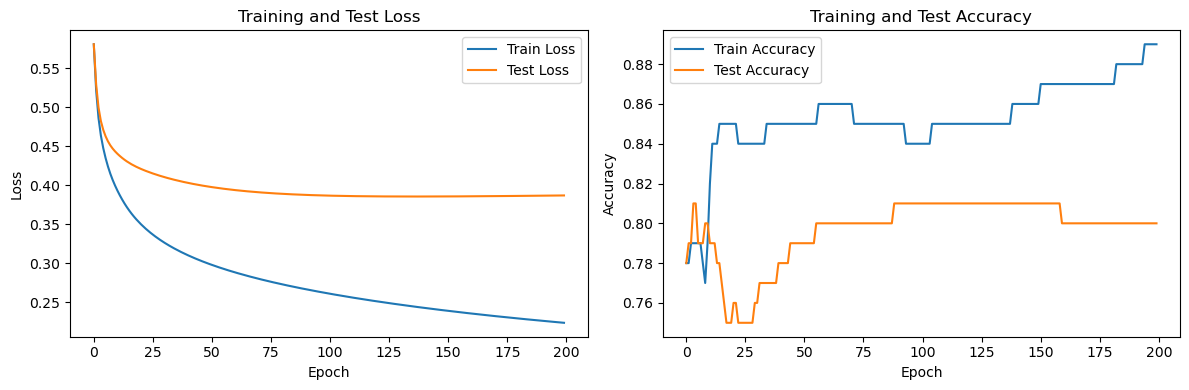

In [11]:
# plot model1
plot_loss_and_accuracy(train_loss, test_loss, train_acc, test_acc)

##### Instantiate the more complex model NeuralNetwork2

In [12]:
# create a model instance
model2 = NeuralNetwork2()

# print the model size (number of parameters)
num_params = sum(p.numel() for p in model2.parameters())
print("Number of parameters:", num_params)

Number of parameters: 25089


##### Define optimizer2 for training model2

In [13]:
# define optimizer2
optimizer2 = torch.optim.Adam(model2.parameters(), lr = learning_rate, weight_decay = weight_decay)

# train model2
train_loss, test_loss, train_acc, test_acc = train_network(model2, optimizer2, loss_function, num_epochs, batch_size, X_train, y_train, X_test, y_test)

Epoch   0 | TrainLoss = 0.4724 | TestLoss = 0.4950 | TrainAcc = 0.760 | TestAcc = 0.800
Epoch  10 | TrainLoss = 0.2161 | TestLoss = 0.3440 | TrainAcc = 0.900 | TestAcc = 0.820
Epoch  20 | TrainLoss = 0.1399 | TestLoss = 0.3314 | TrainAcc = 0.940 | TestAcc = 0.850
Epoch  30 | TrainLoss = 0.0894 | TestLoss = 0.3196 | TrainAcc = 0.980 | TestAcc = 0.880
Epoch  40 | TrainLoss = 0.0566 | TestLoss = 0.3185 | TrainAcc = 1.000 | TestAcc = 0.870
Epoch  50 | TrainLoss = 0.0364 | TestLoss = 0.3262 | TrainAcc = 1.000 | TestAcc = 0.870
Epoch  60 | TrainLoss = 0.0242 | TestLoss = 0.3396 | TrainAcc = 1.000 | TestAcc = 0.880
Epoch  70 | TrainLoss = 0.0168 | TestLoss = 0.3531 | TrainAcc = 1.000 | TestAcc = 0.880
Epoch  80 | TrainLoss = 0.0122 | TestLoss = 0.3680 | TrainAcc = 1.000 | TestAcc = 0.880
Epoch  90 | TrainLoss = 0.0092 | TestLoss = 0.3822 | TrainAcc = 1.000 | TestAcc = 0.890
Epoch 100 | TrainLoss = 0.0070 | TestLoss = 0.3956 | TrainAcc = 1.000 | TestAcc = 0.890
Epoch 110 | TrainLoss = 0.0056 |

##### Plot training history graphs for model2

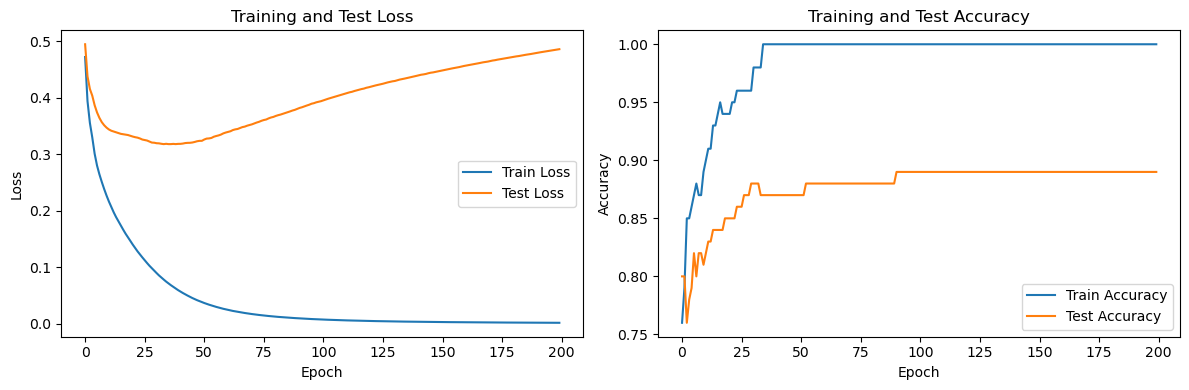

In [14]:
# plot model2
plot_loss_and_accuracy(train_loss, test_loss, train_acc, test_acc)

##### Define a hyperparameter search helper function using NeuralNetwork2

In [15]:
def train_and_score(learning_rate = 0.001, weight_decay = 0.0, batch_size = 16, num_epochs = 200):
 
    
    model = NeuralNetwork2() 

    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)

    train_loss, test_loss, train_acc, test_acc = train_network(model, optimizer, loss_function, num_epochs, batch_size, X_train, y_train, X_test, y_test)

    # best accuracy
    best_train_acc = float(np.max(train_acc))
    best_test_acc = float(np.max(test_acc))

    return {
        "lr": learning_rate,
        "weight_decay": weight_decay,
        "batch_size": batch_size,
        "best_train_acc": best_train_acc,
        "best_test_acc": best_test_acc
    }

In [16]:
lr_list = [0.001, 0.0005, 0.0001]
wd_list = [0.0, 0.0001, 0.001, 0.01, 0.05]
bs_list = [8, 16]

all_results = []

for lr in lr_list:
    for wd in wd_list:
        for bs in bs_list:
            print(f"\n====================== Running: lr = {lr}, wd = {wd}, bs = {bs} ======================")
            result = train_and_score(learning_rate = lr, weight_decay = wd, batch_size = bs, num_epochs = 200)
            all_results.append(result)
            print(f"  -> best_train_acc = {result['best_train_acc']:.3f} | best_test_acc = {result['best_test_acc']:.3f}")



# best of best_test_acc
best_config = max(all_results, key=lambda x: x["best_test_acc"])
print("\nBEST CONFIG")
print(best_config)

# sort result by test accuracy
all_results_sorted = sorted(all_results, key=lambda x: x["best_test_acc"], reverse=True)
print("\nTop 5 configs:")
for result in all_results_sorted[:5]:
    print(result)


====================== Running: lr = 0.001, wd = 0.0, bs = 8 ======================
Epoch   0 | TrainLoss = 0.4409 | TestLoss = 0.4873 | TrainAcc = 0.740 | TestAcc = 0.750
Epoch  10 | TrainLoss = 0.1682 | TestLoss = 0.3420 | TrainAcc = 0.930 | TestAcc = 0.830
Epoch  20 | TrainLoss = 0.0888 | TestLoss = 0.3259 | TrainAcc = 0.980 | TestAcc = 0.860
Epoch  30 | TrainLoss = 0.0479 | TestLoss = 0.3336 | TrainAcc = 1.000 | TestAcc = 0.860
Epoch  40 | TrainLoss = 0.0264 | TestLoss = 0.3547 | TrainAcc = 1.000 | TestAcc = 0.880
Epoch  50 | TrainLoss = 0.0157 | TestLoss = 0.3767 | TrainAcc = 1.000 | TestAcc = 0.880
Epoch  60 | TrainLoss = 0.0100 | TestLoss = 0.4016 | TrainAcc = 1.000 | TestAcc = 0.890
Epoch  70 | TrainLoss = 0.0069 | TestLoss = 0.4223 | TrainAcc = 1.000 | TestAcc = 0.890
Epoch  80 | TrainLoss = 0.0050 | TestLoss = 0.4422 | TrainAcc = 1.000 | TestAcc = 0.890
Epoch  90 | TrainLoss = 0.0037 | TestLoss = 0.4589 | TrainAcc = 1.000 | TestAcc = 0.890
Epoch 100 | TrainLoss = 0.0029 | Te

##### Save results to hyperparameter_search_results.csv

In [17]:
all_results_df = pd.DataFrame(all_results)
all_results_df.to_csv("hyperparameter_search_results.csv", index=False)

##### Visualise heatmap-style results of hyperparameter search

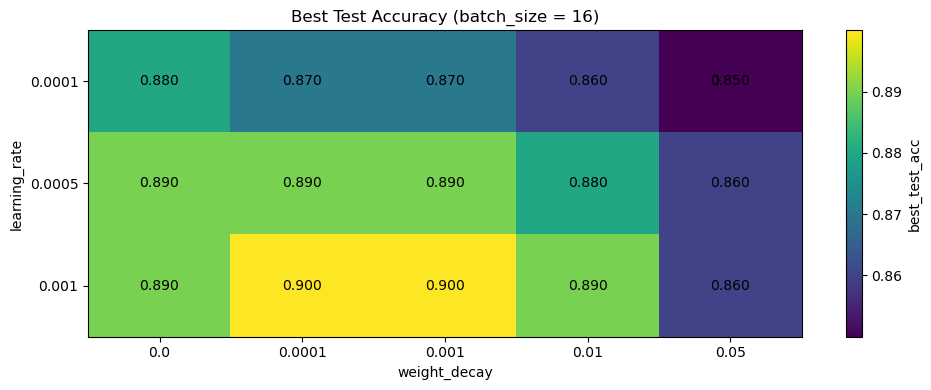

In [18]:
def plot_heatmap_like(df, batch_size):
    sub = df[df["batch_size"] == batch_size].copy()

    pivot = sub.pivot(index = "lr", columns = "weight_decay", values = "best_test_acc")

    plt.figure(figsize = (10, 4))
    plt.imshow(pivot.values, aspect = "auto")
    plt.xticks(range(pivot.shape[1]), pivot.columns)
    plt.yticks(range(pivot.shape[0]), pivot.index)
    plt.xlabel("weight_decay")
    plt.ylabel("learning_rate")
    plt.title(f"Best Test Accuracy (batch_size = {batch_size})")

    # put values inside each grid cell
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            plt.text(j, i, f"{pivot.values[i, j]:.3f}", ha = "center", va = "center")

    plt.colorbar(label = "best_test_acc")
    plt.tight_layout()
    plt.show()
plot_heatmap_like(all_results_df, batch_size = 16)

##### Visualise a multi-line plot to show the effect of weight decay on test accuracy

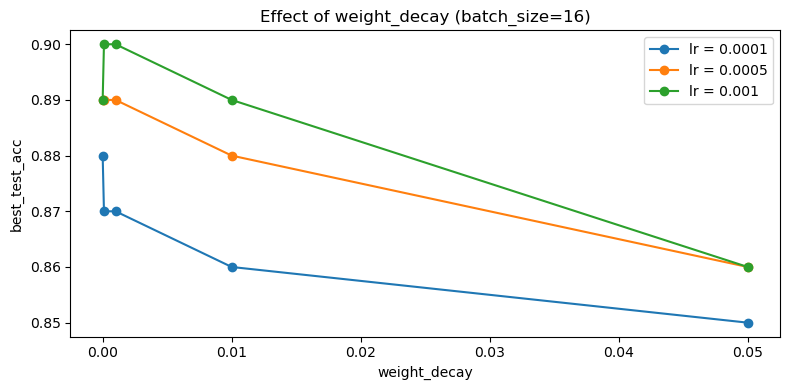

In [19]:
def plot_wd_trend(df, batch_size):
    sub = df[df["batch_size"] == batch_size].copy()
    lrs = sorted(sub["lr"].unique())

    plt.figure(figsize = (8, 4))
    for lr in lrs:
        one = sub[sub["lr"] == lr].sort_values("weight_decay")
        plt.plot(one["weight_decay"], one["best_test_acc"], marker = "o", label = f"lr = {lr}")

    plt.xlabel("weight_decay")
    plt.ylabel("best_test_acc")
    plt.title(f"Effect of weight_decay (batch_size={batch_size})")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_wd_trend(all_results_df, batch_size = 16)